In [78]:
from bs4 import BeautifulSoup
import requests
import re
import time
import random
import pandas as pd
from tqdm.notebook import tqdm
from typing import List

In [93]:
def get_listings(soup: BeautifulSoup, city: str) -> List:
    data = []

    for i in soup.find_all('li', class_='search-list__item search-list__item--listing'):
        title = i.find(class_='listing-search-item__link listing-search-item__link--title').text
        link = 'https://pararius.com' + i.find(class_='listing-search-item__link listing-search-item__link--title')['href']
        
        price = i.find(class_='listing-search-item__price').text
        
        price = re.findall(f'€[\d]+', price.replace(',', ''))

        if len(price) == 0:
            price = None
        else:
            price = price[0][1:]

        location = i.find(class_='listing-search-item__location').text
        location = re.sub('[\s]{2,}', '', location)

        rooms = i.find(class_='illustrated-features__item illustrated-features__item--number-of-rooms').text
        rooms = re.findall(f'[\d]+', rooms)[0]

        area = i.find(class_='illustrated-features__item illustrated-features__item--surface-area')
        area = re.findall(f'[\d]+', area.text)[0] if area is not None else None
        
        interior = i.find(class_='illustrated-features__item illustrated-features__item--interior')
        interior = interior.text if interior is not None else None

        listing = {
            'title': title,
            'link': link,
            'price': price,
            'location': location,
            'area': area,
            'rooms': rooms,
            'interior': interior,
            'city': city
        }
        data.append(listing)
    
    return data

In [49]:
cities_str = """Appartments for rent Alkmaar
Appartments for rent Almere
Appartments for rent Amersfoort
Appartments for rent Amstelveen
Appartments for rent Amsterdam
Appartments for rent Apeldoorn
Appartments for rent Arnhem
Appartments for rent Breda
Appartments for rent Bussum
Appartments for rent Delft
Appartments for rent Den Bosch
Appartments for rent Den Haag
Appartments for rent Deventer
Appartments for rent Dordrecht
Appartments for rent Eindhoven
Appartments for rent Enschede
Appartments for rent Groningen
Appartments for rent Haarlem
Appartments for rent Heerlen
Appartments for rent Hilversum
Appartments for rent Leeuwarden
Appartments for rent Leiden
Appartments for rent Maastricht
Appartments for rent Nijmegen
Appartments for rent Roermond
Appartments for rent Rotterdam
Appartments for rent Tilburg
Appartments for rent Utrecht
Appartments for rent Zaandam
Appartments for rent Zwolle"""

cities = [c.replace('Appartments for rent ', '') for c in cities_str.split('\n')]

city_counts = []
for c in tqdm(cities):
    r = requests.get('https://www.pararius.com/apartments/' + c.lower())

    soup = BeautifulSoup(r.text)
    count = soup.find(class_='search-list-header__count')

    city_counts.append({'city': c, 'count': int(count.text) if count is not None else 0})

    time.sleep(random.randint(10, 20))

top_cities = sorted(city_counts, key = lambda x: x['count'], reverse=True)
top_cities = [c for c in top_cities if c['count'] != 0]

In [119]:
city_data = []

with tqdm(top_cities) as t:
    for c in t:
        city = c['city']
        t.set_description('Parsing ' + city)

        r = requests.get('https://www.pararius.com/apartments/' + city.lower())
        soup = BeautifulSoup(r.text)

        city_data.extend(get_listings(soup, city))

        time.sleep(15)

        pg = 2
        while True:
            next_button = soup.find(class_='pagination__link pagination__link--next')
            if next_button is not None:
                t.set_description(f'Parsing {city} (Page: {pg})')
                r = requests.get('https://www.pararius.com' + next_button['href'])

                soup = BeautifulSoup(r.text)
                city_data.extend(get_listings(soup, city))
            else:
                break
            
            pg += 1
            time.sleep(15)

  0%|          | 0/18 [00:00<?, ?it/s]

In [134]:
df = pd.DataFrame(city_data)
df = df[~df['price'].isna()]
df_ = df.astype({'price': 'int64', 'area': 'int64', 'rooms': 'int64'})
df.head(10)

,title,link,price,location,area,rooms,interior,city
0,Apartment Oudezijds Achterburgwal,https://pararius.com/apartment-for-rent/amster...,1395,1012 DE Amsterdam (Burgwallen-Oude Zijde),40,2,Upholstered,Amsterdam
1,Apartment Singel,https://pararius.com/apartment-for-rent/amster...,3000,1016 AA Amsterdam (Grachtengordel-West),125,3,Upholstered,Amsterdam
2,Apartment Valeriusstraat,https://pararius.com/apartment-for-rent/amster...,2150,1075 ET Amsterdam (Willemspark),85,2,Upholstered,Amsterdam
3,Apartment Eerste Weteringdwarsstraat,https://pararius.com/apartment-for-rent/amster...,1550,1017 TP Amsterdam (De Weteringschans),45,2,Upholstered,Amsterdam
4,Apartment Haparandaweg,https://pararius.com/apartment-for-rent/amster...,1475,1013 BD Amsterdam (Houthavens),40,2,Furnished,Amsterdam
5,Apartment Prins Hendriklaan,https://pararius.com/apartment-for-rent/amster...,2150,1075 BE Amsterdam (Willemspark),90,4,Upholstered,Amsterdam
6,Apartment Van Nijenrodeweg,https://pararius.com/apartment-for-rent/amster...,2150,1083 EG Amsterdam (Buitenveldert-Oost),90,3,Furnished,Amsterdam
7,Apartment Faas Wilkesstraat 475,https://pararius.com/apartment-for-rent/amster...,1500,1095 MD Amsterdam (Zeeburgereiland/Nieuwe Diep),76,3,Upholstered,Amsterdam
8,Apartment Aurikelstraat 53,https://pararius.com/apartment-for-rent/amster...,1500,1032 AR Amsterdam (Volewijck),61,3,None,Amsterdam
9,Apartment Zandvoortstraat 40,https://pararius.com/apartment-for-rent/amster...,1750,1024 VT Amsterdam (Waterlandpleinbuurt),85,4,None,Amsterdam


<AxesSubplot:>

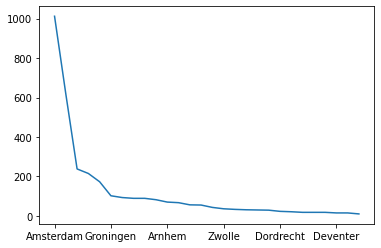

In [130]:
df['city'].value_counts().plot()

In [186]:
import sqlalchemy 

db = sqlalchemy.create_engine('sqlite:///housing.db')

df_.to_sql(name='housing', con=db, index=False)
db.dispose()

df_.to_parquet('dutch_housing.parquet', index=False)